In [ ]:
from helper import split_name
from read_data import pull_data, prepare_data, get_expert_projections
from modeling import split_data_random, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, finalize_predictions, split_batters_if_of, create_draft_pool, calculate_relative_value, determine_optimal_k, segment_players
from config import BAT_POS_OVERRIDES, AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, param_space
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

FORMAT = "UD" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 415182

# Dampening parameter for MLB positional groups, helpful for re-balancing rankings based on positional ADP demands
POS_DAMPENING_MAP = {
    "P": 0.95,    
    "IF": 0.9,   
    "OF": 1.1,   
}

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [42]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [43]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Pulling data for year: 2005
Pulling data for year: 2006
Pulling data for year: 2007
Pulling data for year: 2008
Pulling data for year: 2009
Pulling data for year: 2010
Pulling data for year: 2011
Pulling data for year: 2012
Pulling data for year: 2013
Pulling data for year: 2014
Pulling data for year: 2015
Pulling data for year: 2016
Pulling data for year: 2017
Pulling data for year: 2018
Pulling data for year: 2019
Pulling data for year: 2020
Pulling data for year: 2021
Pulling data for year: 2022
Pulling data for year: 2023
Pulling data for year: 2024
Pulling data for year: 2025
Data saved successfully (parquet).
Data pull & feature engineering complete.


In [4]:
# TODO: Fix up n_estimators documentation
# TODO: Create a feature_engineering.py file

# Pulling FantasyPros Projection Data

In [5]:
batting_projections, pitching_projections = get_expert_projections(
    batting_url=batting_url,
    pitching_url=pitching_url,
    fmt=FORMAT,
    scoring_rules=SCORING_RULES,
)

# Creating Batting Model

## Creating baseline batting predictions

In [6]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

# Compiling baseline predictions
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp.head(10))

[Test] RMSE: 314.683 | MAE: 248.655 | R^2: 0.491 | Spearman: 0.699


,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
290,Albert Pujols,1628.0,1791.190308,163.190308,163.190308,2006,26,1806.0
659,Aaron Judge,1185.0,1664.927002,479.927002,479.927002,2022,30,1992.0
59,Derrek Lee,460.0,1614.862671,1154.862671,1154.862671,2005,29,1868.0
109,Anthony Rizzo,1571.0,1612.805420,41.805420,41.805420,2015,25,1617.0
506,Hanley Ramirez,1806.0,1600.453247,-205.546753,205.546753,2006,22,1607.0
325,Hanley Ramirez,1708.0,1593.183594,-114.816406,114.816406,2007,23,1806.0
752,Bobby Abreu,1638.0,1581.757812,-56.242188,56.242188,2005,31,1693.0
174,Miguel Cabrera,1606.0,1579.277466,-26.722534,26.722534,2006,23,1703.0
503,Miguel Cabrera,1718.0,1556.518921,-161.481079,161.481079,2010,27,1708.0
153,Anthony Rizzo,1391.0,1495.672607,104.672607,104.672607,2017,27,1604.0


# Building Batting Model

# Batting Predictions

In [7]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=75,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=50,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 75/75 [08:17<00:00,  6.63s/trial, best loss: 295.0444471156166] 
[Early stopping summary] mean=467, min=89, max=1606
Best Parameters: {'learning_rate': 0.026841446507457623, 'max_leaves': 26, 'grow_policy': 'lossguide', 'subsample': 0.8349719620088196, 'colsample_bytree': 0.691376867166718, 'min_child_weight': 0.39592477960116007, 'reg_lambda': 0.4326253017083251, 'reg_alpha': 0.036008133917585186, 'gamma': 0.00037288658193152587}
[Best trial @ val] optimized=rmse | RMSE=295.044 | MAE=232.708 | R^2=0.534 | SPEAR=0.726 


Bootstrapping prediction intervals: 100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


In [8]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],        
)

[Test] RMSE: 309.174 | MAE: 246.065 | R^2: 0.509 | SPEAR: 0.714


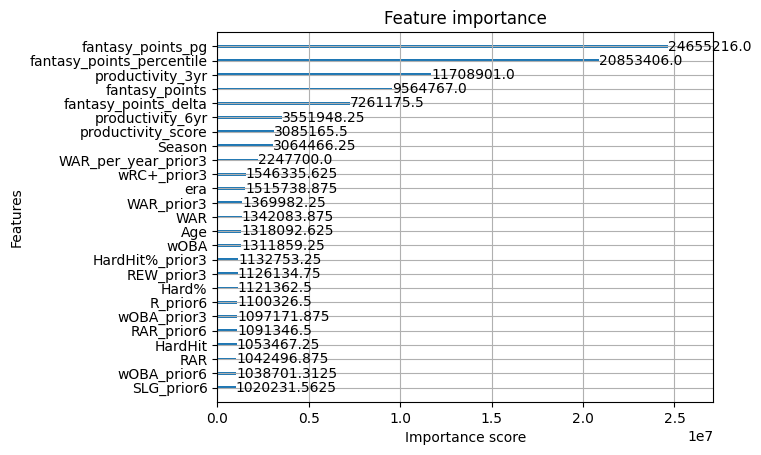

In [9]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [10]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
290,Albert Pujols,1628.0,1750.829956,122.829956,122.829956,2006,26,1806.0
659,Aaron Judge,1185.0,1704.566772,519.566772,519.566772,2022,30,1992.0
174,Miguel Cabrera,1606.0,1637.268799,31.268799,31.268799,2006,23,1703.0
506,Hanley Ramirez,1806.0,1630.945068,-175.054932,175.054932,2006,22,1607.0
752,Bobby Abreu,1638.0,1613.531860,-24.468140,24.468140,2005,31,1693.0
59,Derrek Lee,460.0,1611.864380,1151.864380,1151.864380,2005,29,1868.0
122,Giancarlo Stanton,973.0,1565.668579,592.668579,592.668579,2015,25,804.0
205,Grady Sizemore,1058.0,1516.091431,458.091431,458.091431,2008,25,1744.0
503,Miguel Cabrera,1718.0,1504.455933,-213.544067,213.544067,2010,27,1708.0
109,Anthony Rizzo,1571.0,1500.767944,-70.232056,70.232056,2015,25,1617.0


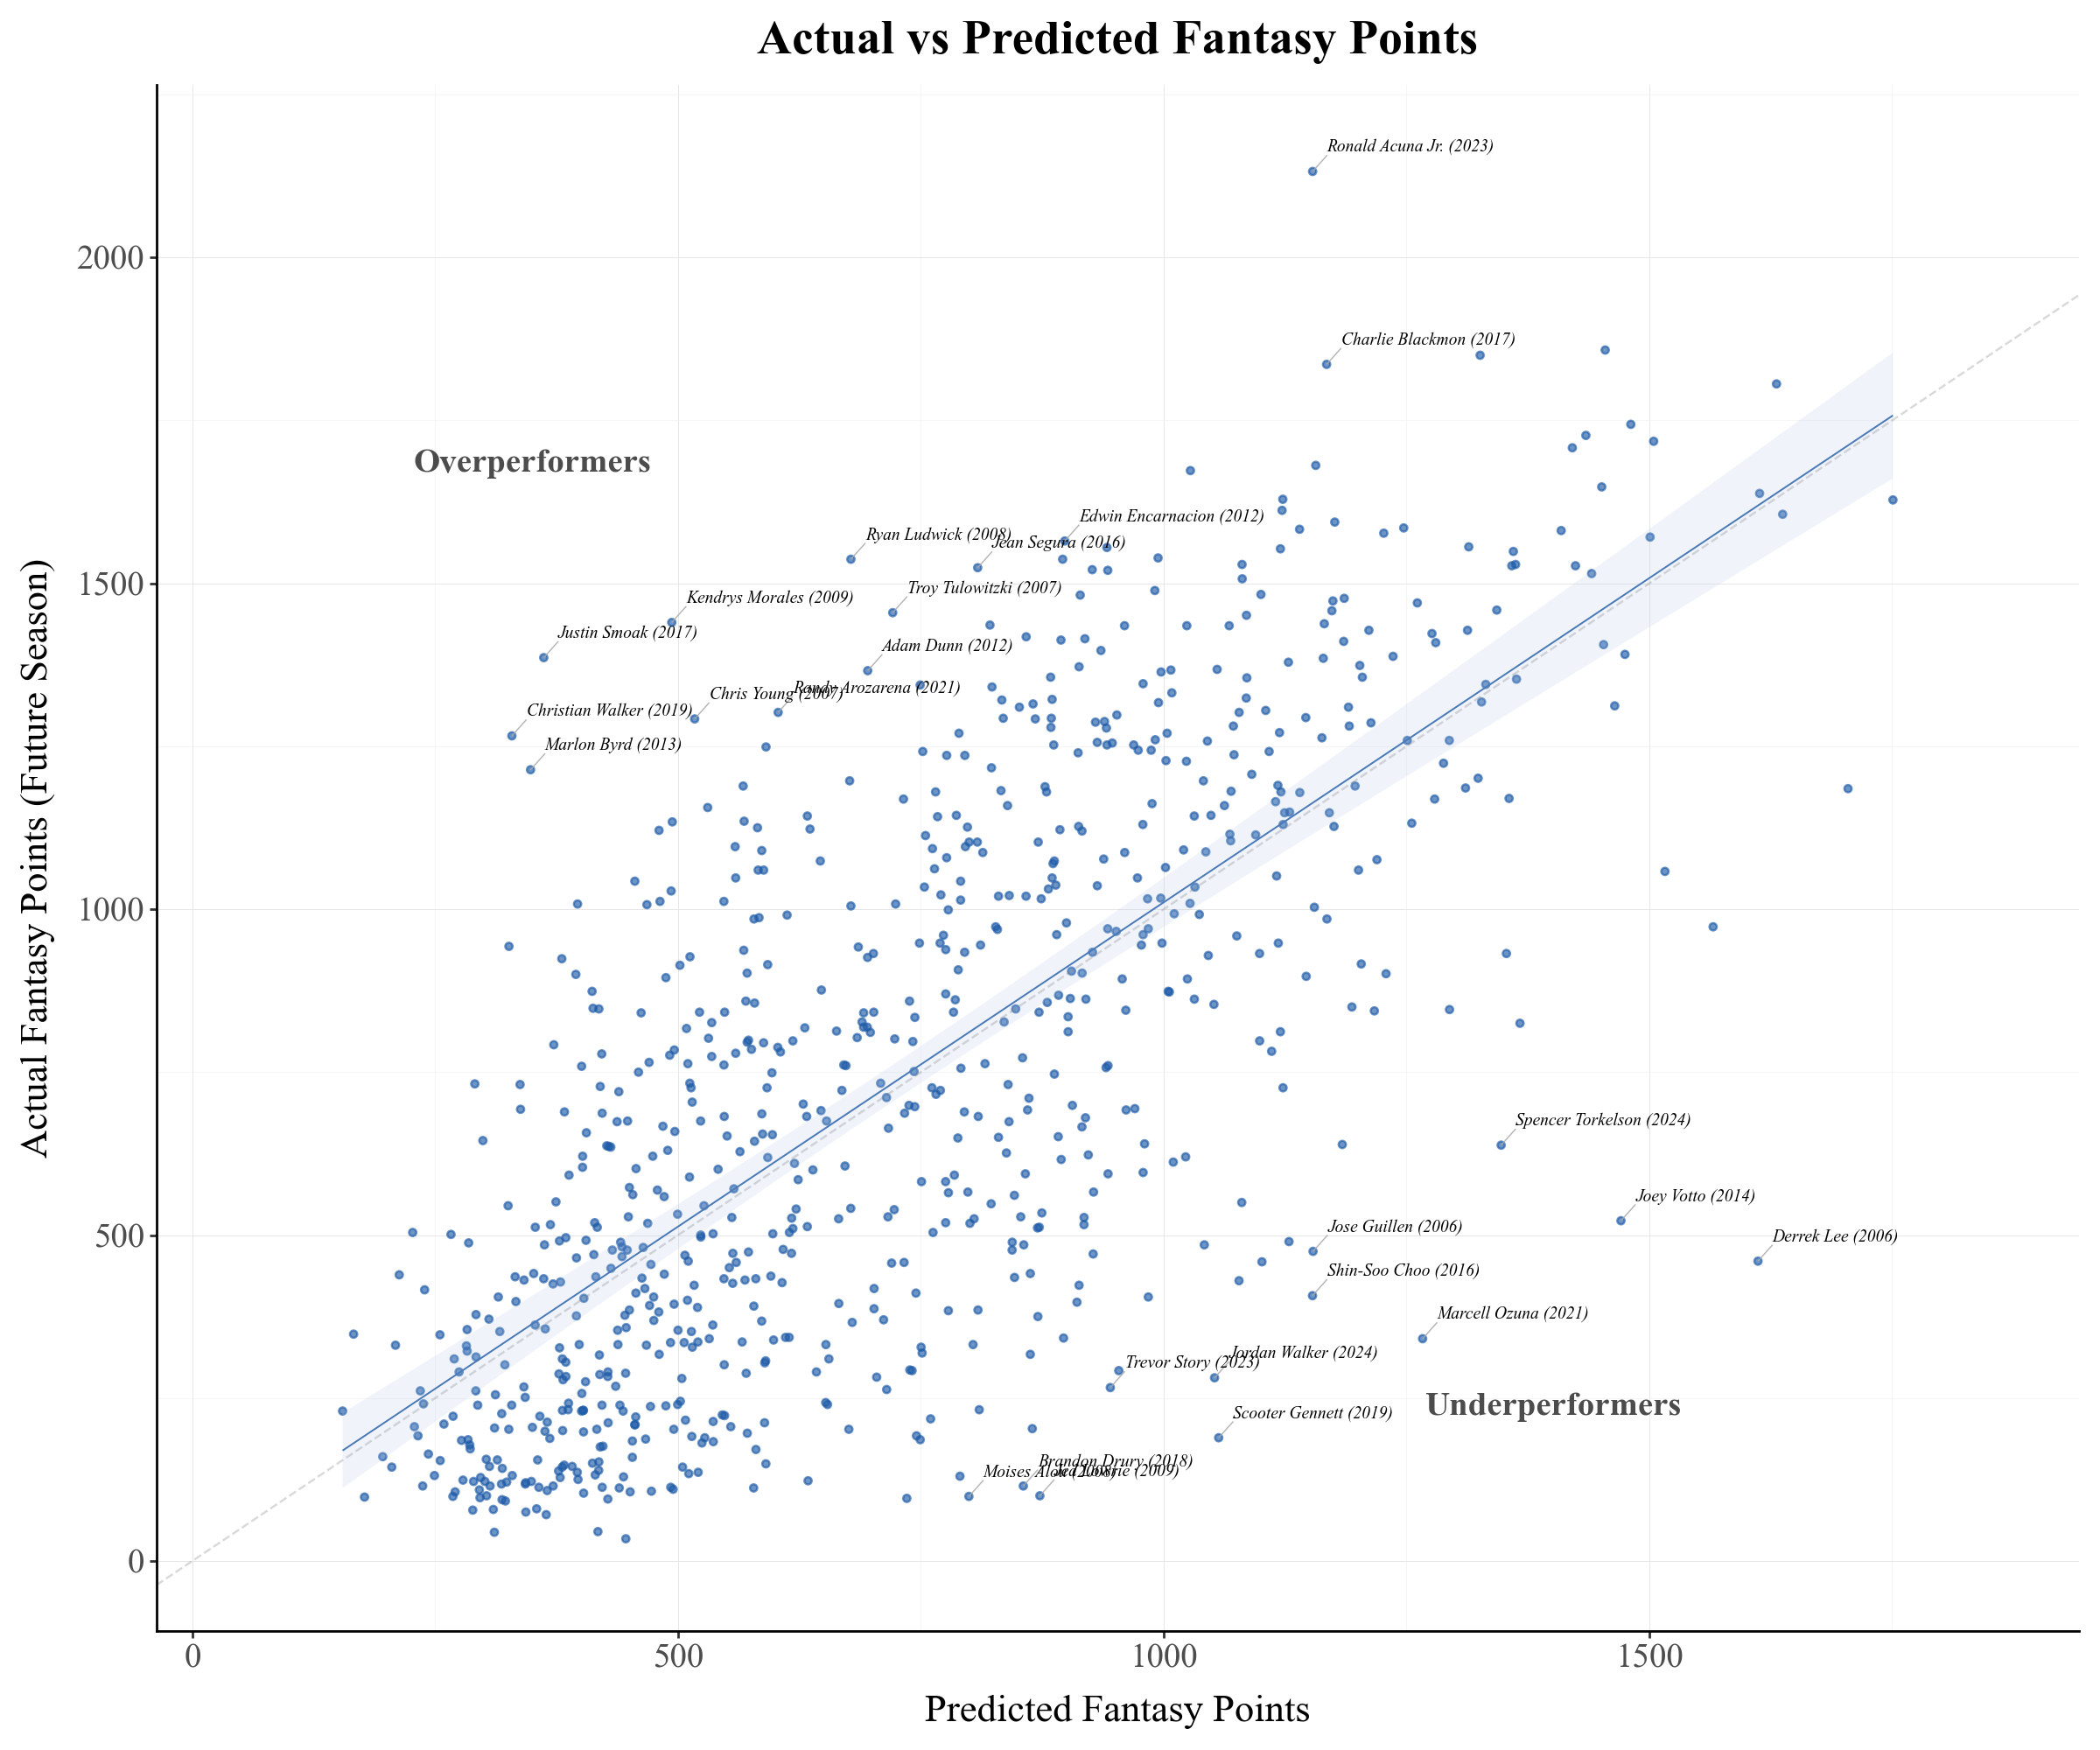

In [11]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

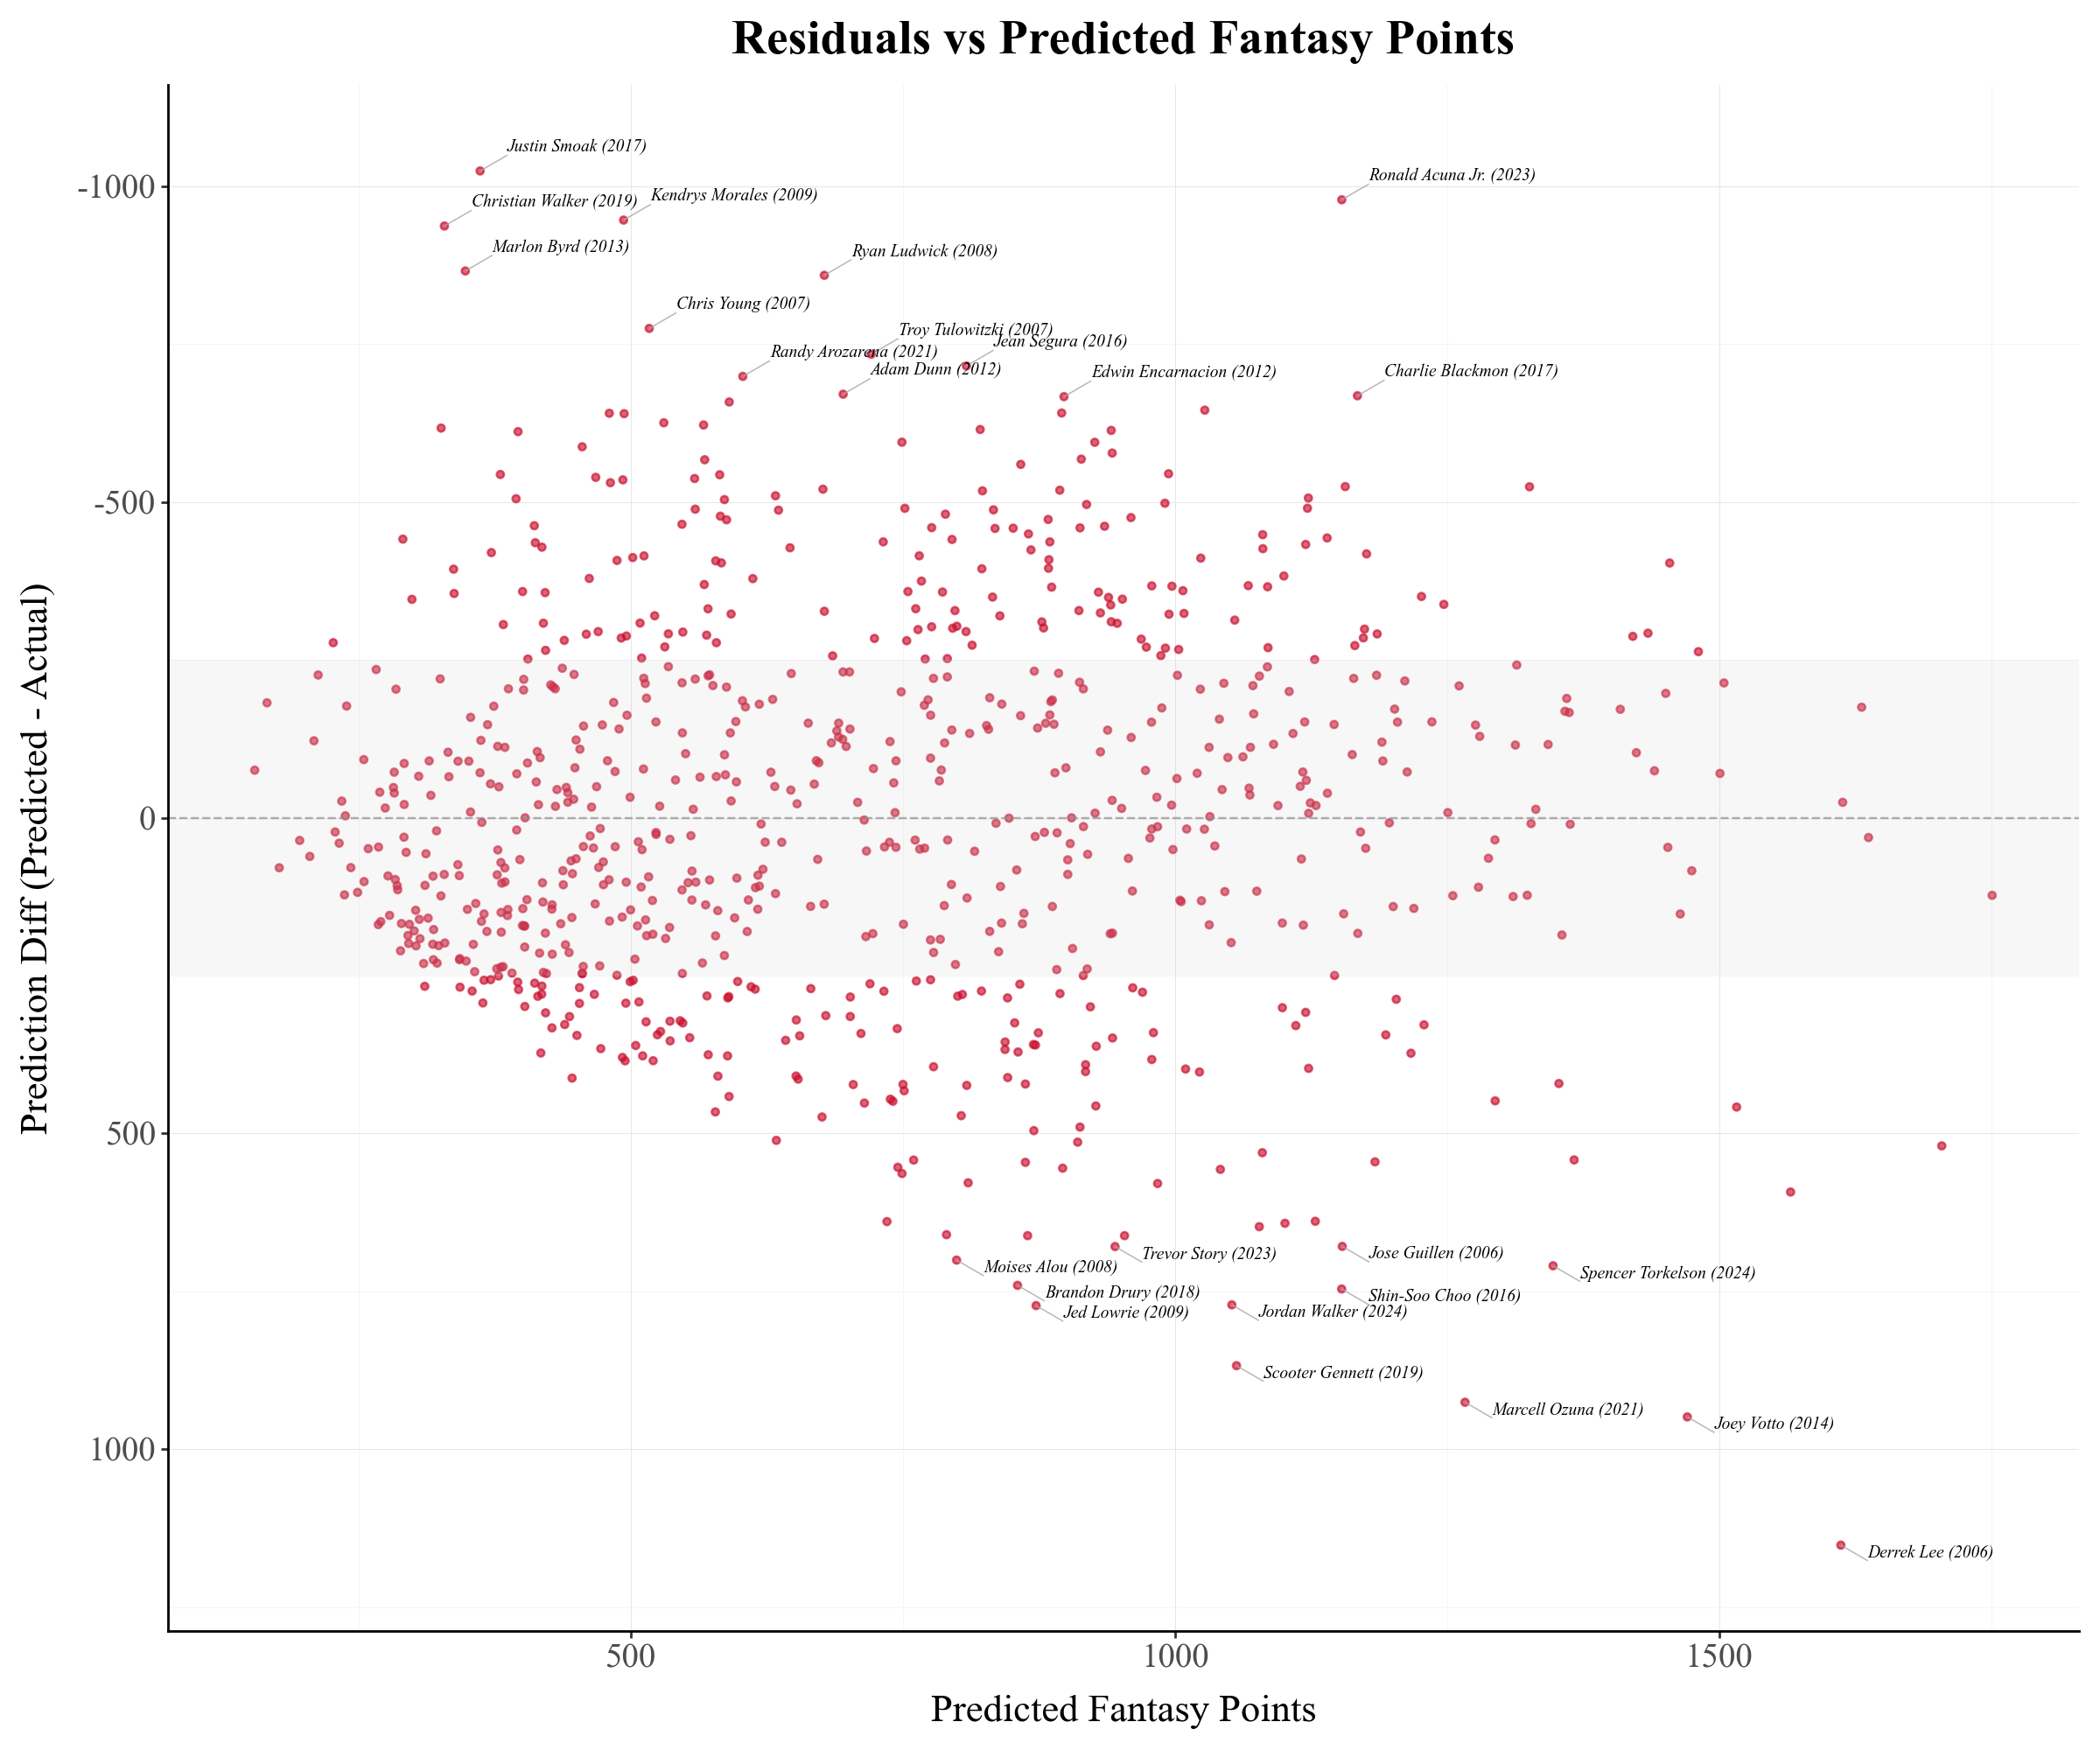

In [12]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=25,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

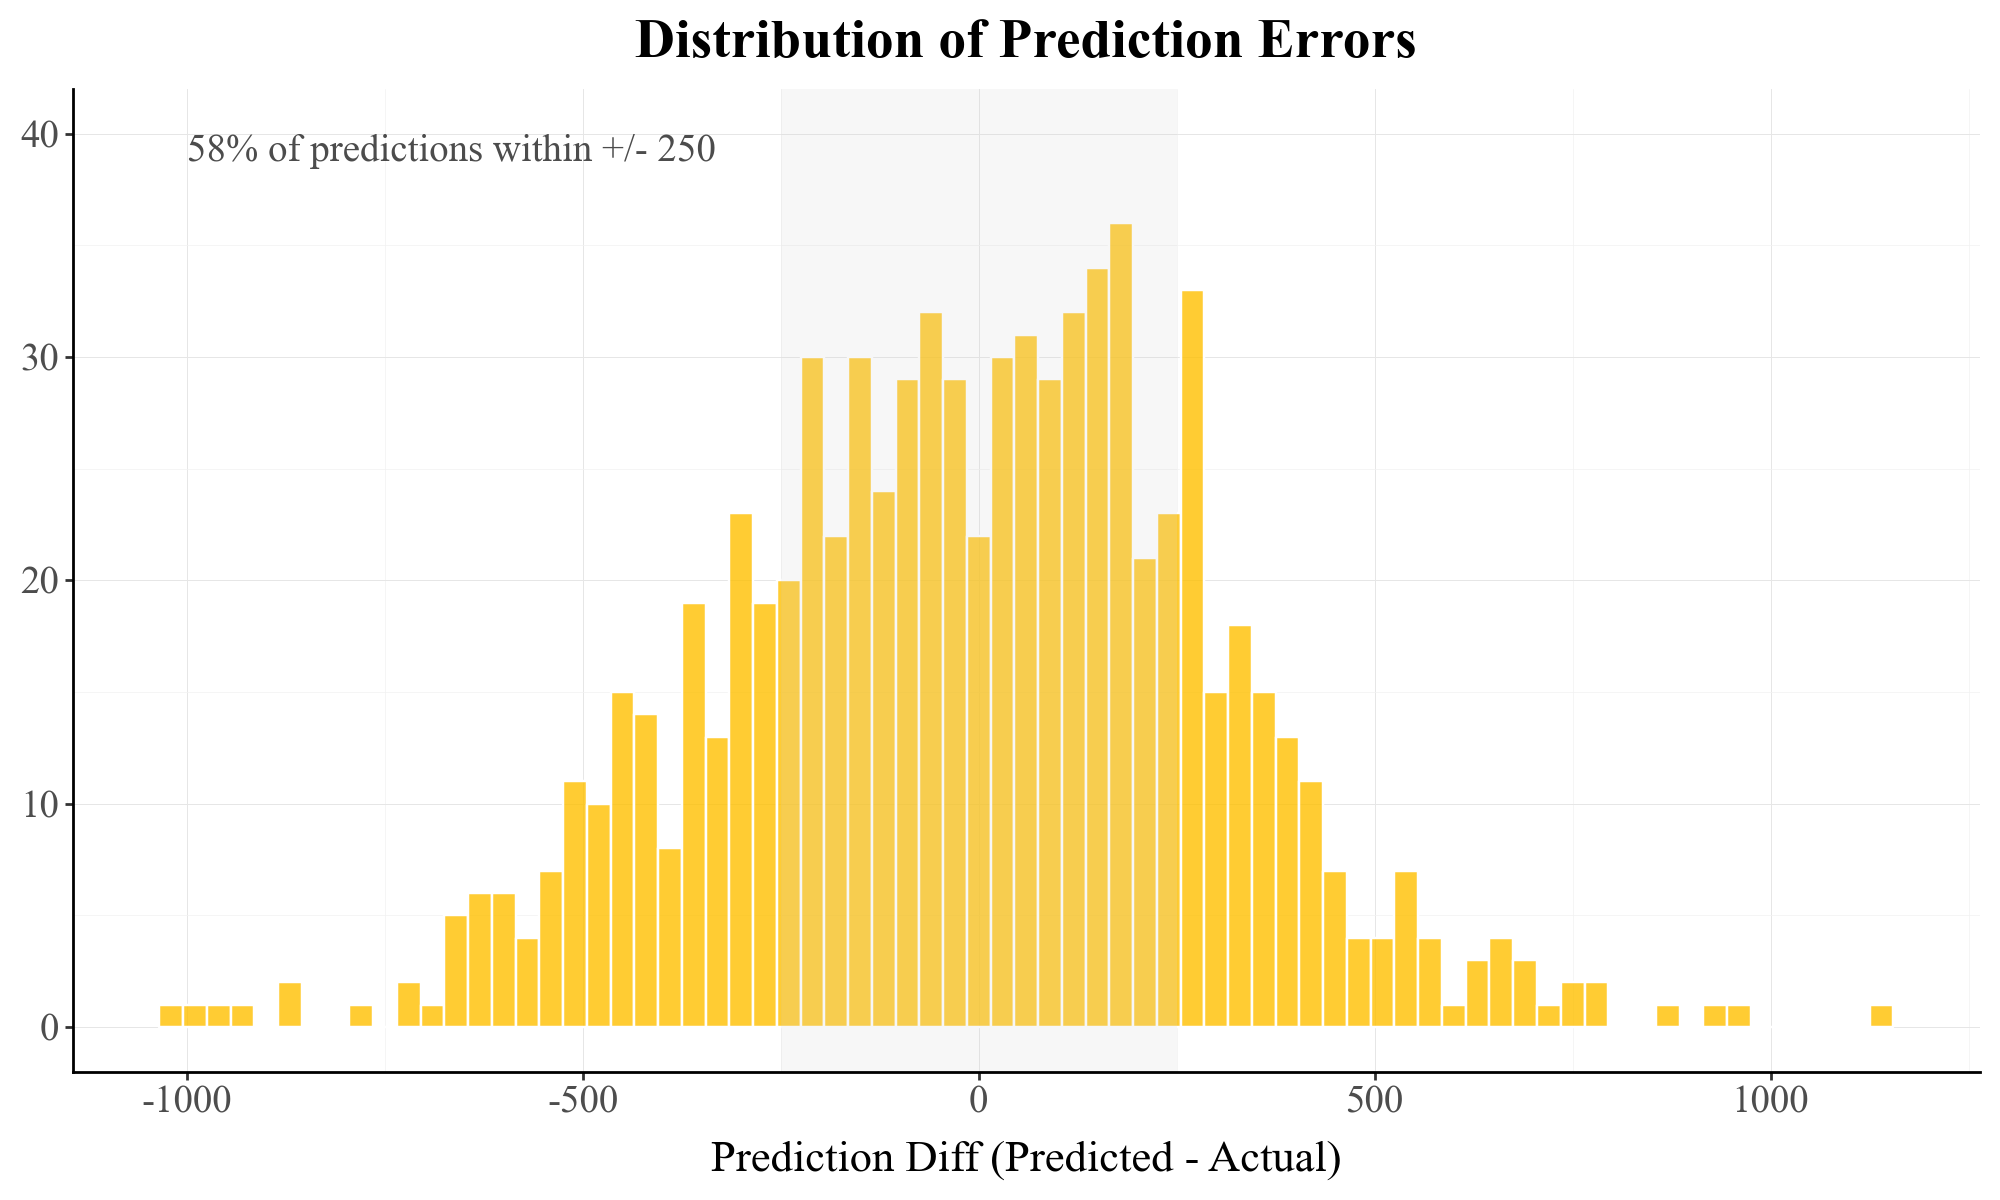

In [ ]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=30,      # custom annotation position
)
p3.show()

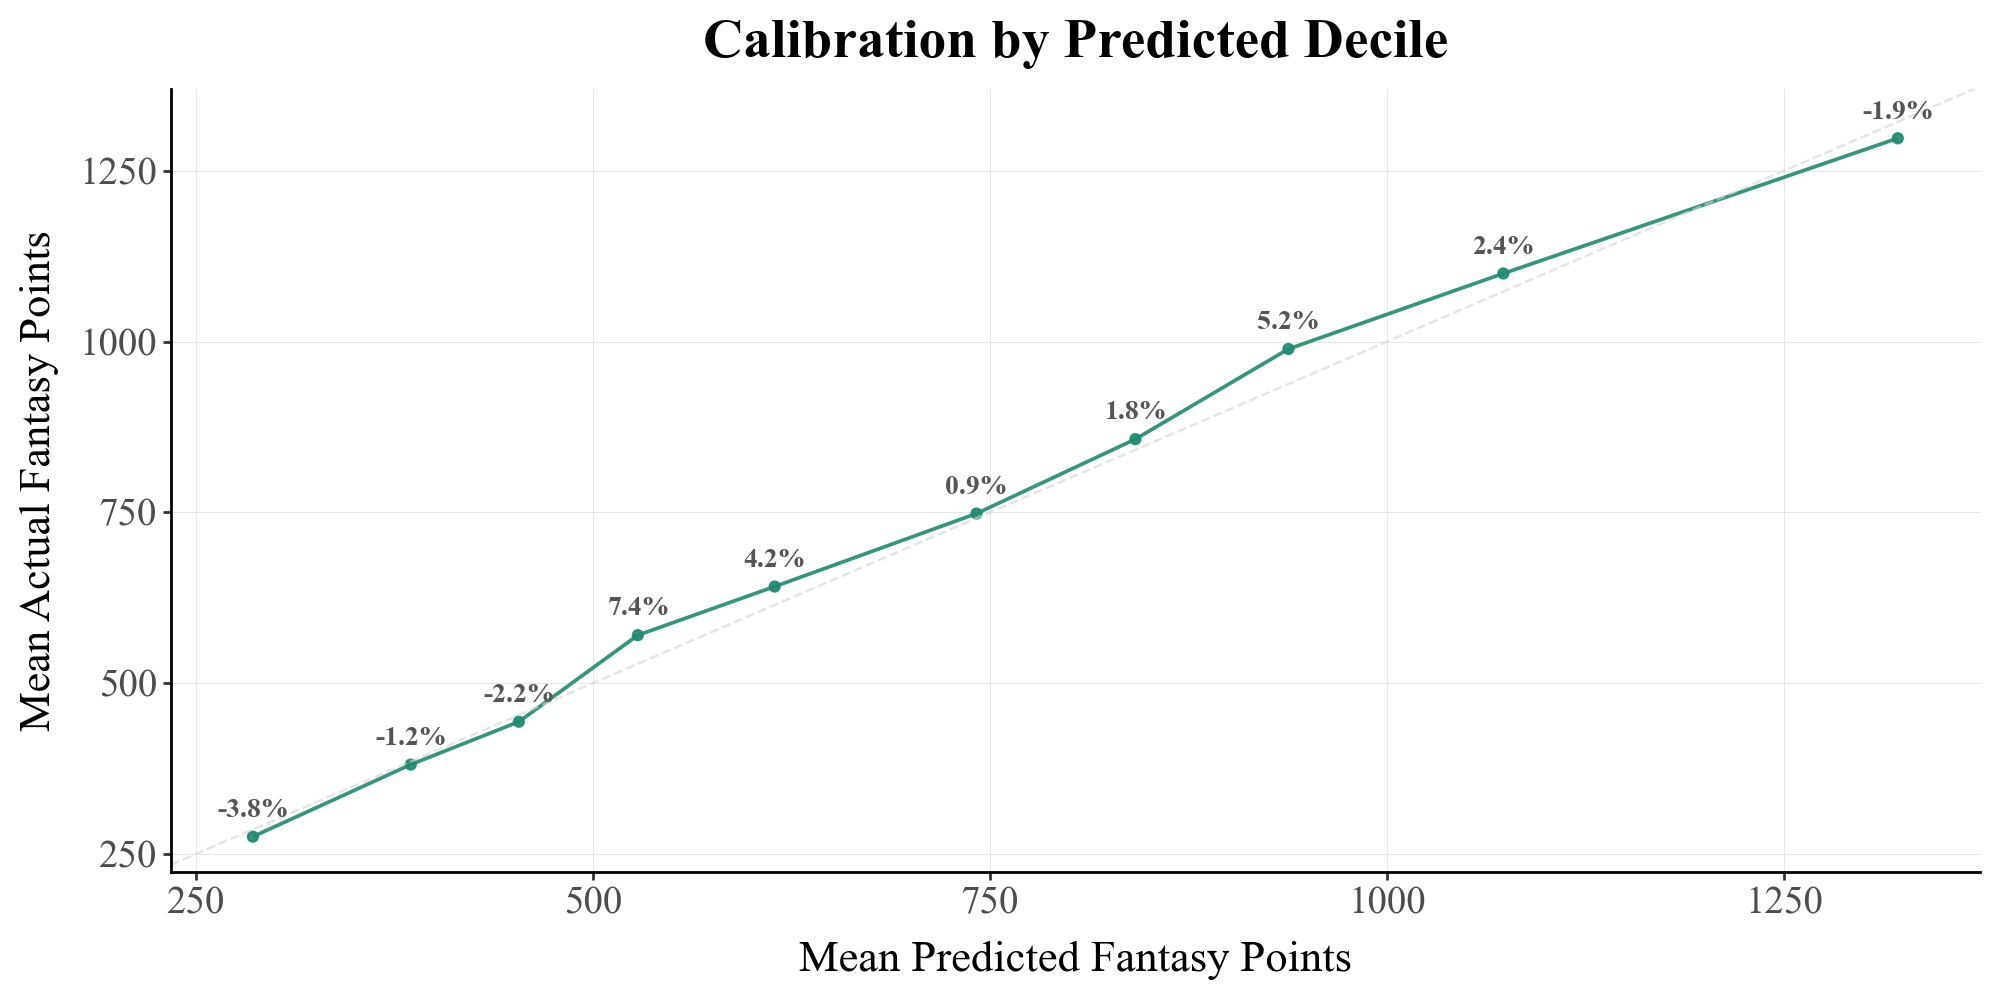

In [14]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [15]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 194.419 | MAE: 147.375 | R^2: 0.498 | Spearman: 0.613


In [16]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
304,Clayton Kershaw,1340.0,1123.092773,-216.907227,216.907227,2012,24,1246.6
292,Chris Carpenter,1062.6,1063.432739,0.832739,0.832739,2005,30,1239.6
307,Brandon Webb,1143.3,1048.717407,-94.582593,94.582593,2006,27,1076.0
199,Tim Lincecum,1178.0,1020.237732,-157.762268,157.762268,2010,26,1166.3
360,Cliff Lee,380.3,982.145325,601.845325,601.845325,2013,34,1189.6
739,Corbin Burnes,1010.6,981.592529,-29.007471,29.007471,2022,27,1197.0
425,Zack Greinke,894.6,978.954346,84.354346,84.354346,2012,28,1065.3
163,Tyson Ross,1061.0,973.328247,-87.671753,87.671753,2014,27,1052.6
311,Cole Hamels,1088.3,973.303894,-114.996106,114.996106,2014,30,1083.6
693,Stephen Strasburg,746.0,969.289368,223.289368,223.289368,2017,28,1065.3


# Pitching Predictions

In [17]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=75,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=50,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 75/75 [05:17<00:00,  4.24s/trial, best loss: 200.9636278575862] 
[Early stopping summary] mean=312, min=46, max=531
Best Parameters: {'learning_rate': 0.012021259867065624, 'max_leaves': 14, 'grow_policy': 'lossguide', 'subsample': 0.8149812677435653, 'colsample_bytree': 0.758303420774932, 'min_child_weight': 4.1305656520692065, 'reg_lambda': 0.08806771002869712, 'reg_alpha': 0.004129074697422507, 'gamma': 3.760439681713033e-05}
[Best trial @ val] optimized=rmse | RMSE=200.964 | MAE=151.035 | R^2=0.503 | SPEAR=0.645 


Bootstrapping prediction intervals: 100%|██████████| 50/50 [03:59<00:00,  4.78s/it]


In [18]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],          
)

[Test] RMSE: 189.225 | MAE: 144.114 | R^2: 0.524 | SPEAR: 0.635


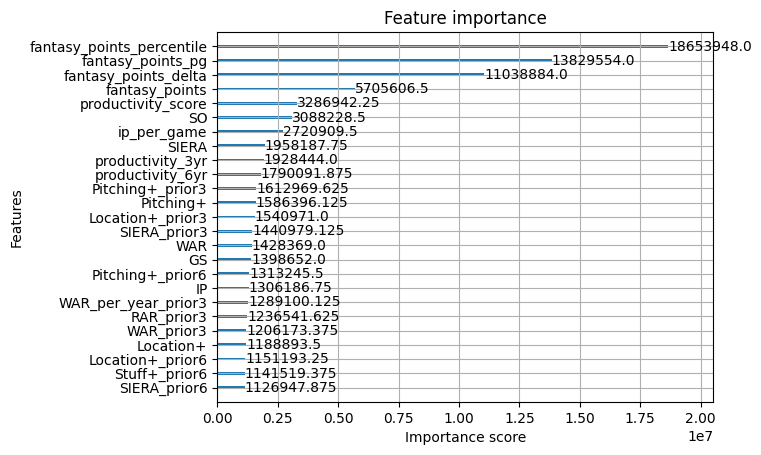

In [19]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [20]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
304,Clayton Kershaw,1340.0,1099.123047,-240.876953,240.876953,2012,24,1246.6
199,Tim Lincecum,1178.0,1046.976685,-131.023315,131.023315,2010,26,1166.3
307,Brandon Webb,1143.3,1009.959778,-133.340222,133.340222,2006,27,1076.0
360,Cliff Lee,380.3,1005.999512,625.699512,625.699512,2013,34,1189.6
292,Chris Carpenter,1062.6,994.637146,-67.962854,67.962854,2005,30,1239.6
693,Stephen Strasburg,746.0,952.658203,206.658203,206.658203,2017,28,1065.3
323,Trevor Bauer,679.6,951.547546,271.947546,271.947546,2020,29,502.0
311,Cole Hamels,1088.3,950.592041,-137.707959,137.707959,2014,30,1083.6
511,David Price,1362.3,943.013062,-419.286938,419.286938,2013,27,854.6
425,Zack Greinke,894.6,933.301392,38.701392,38.701392,2012,28,1065.3


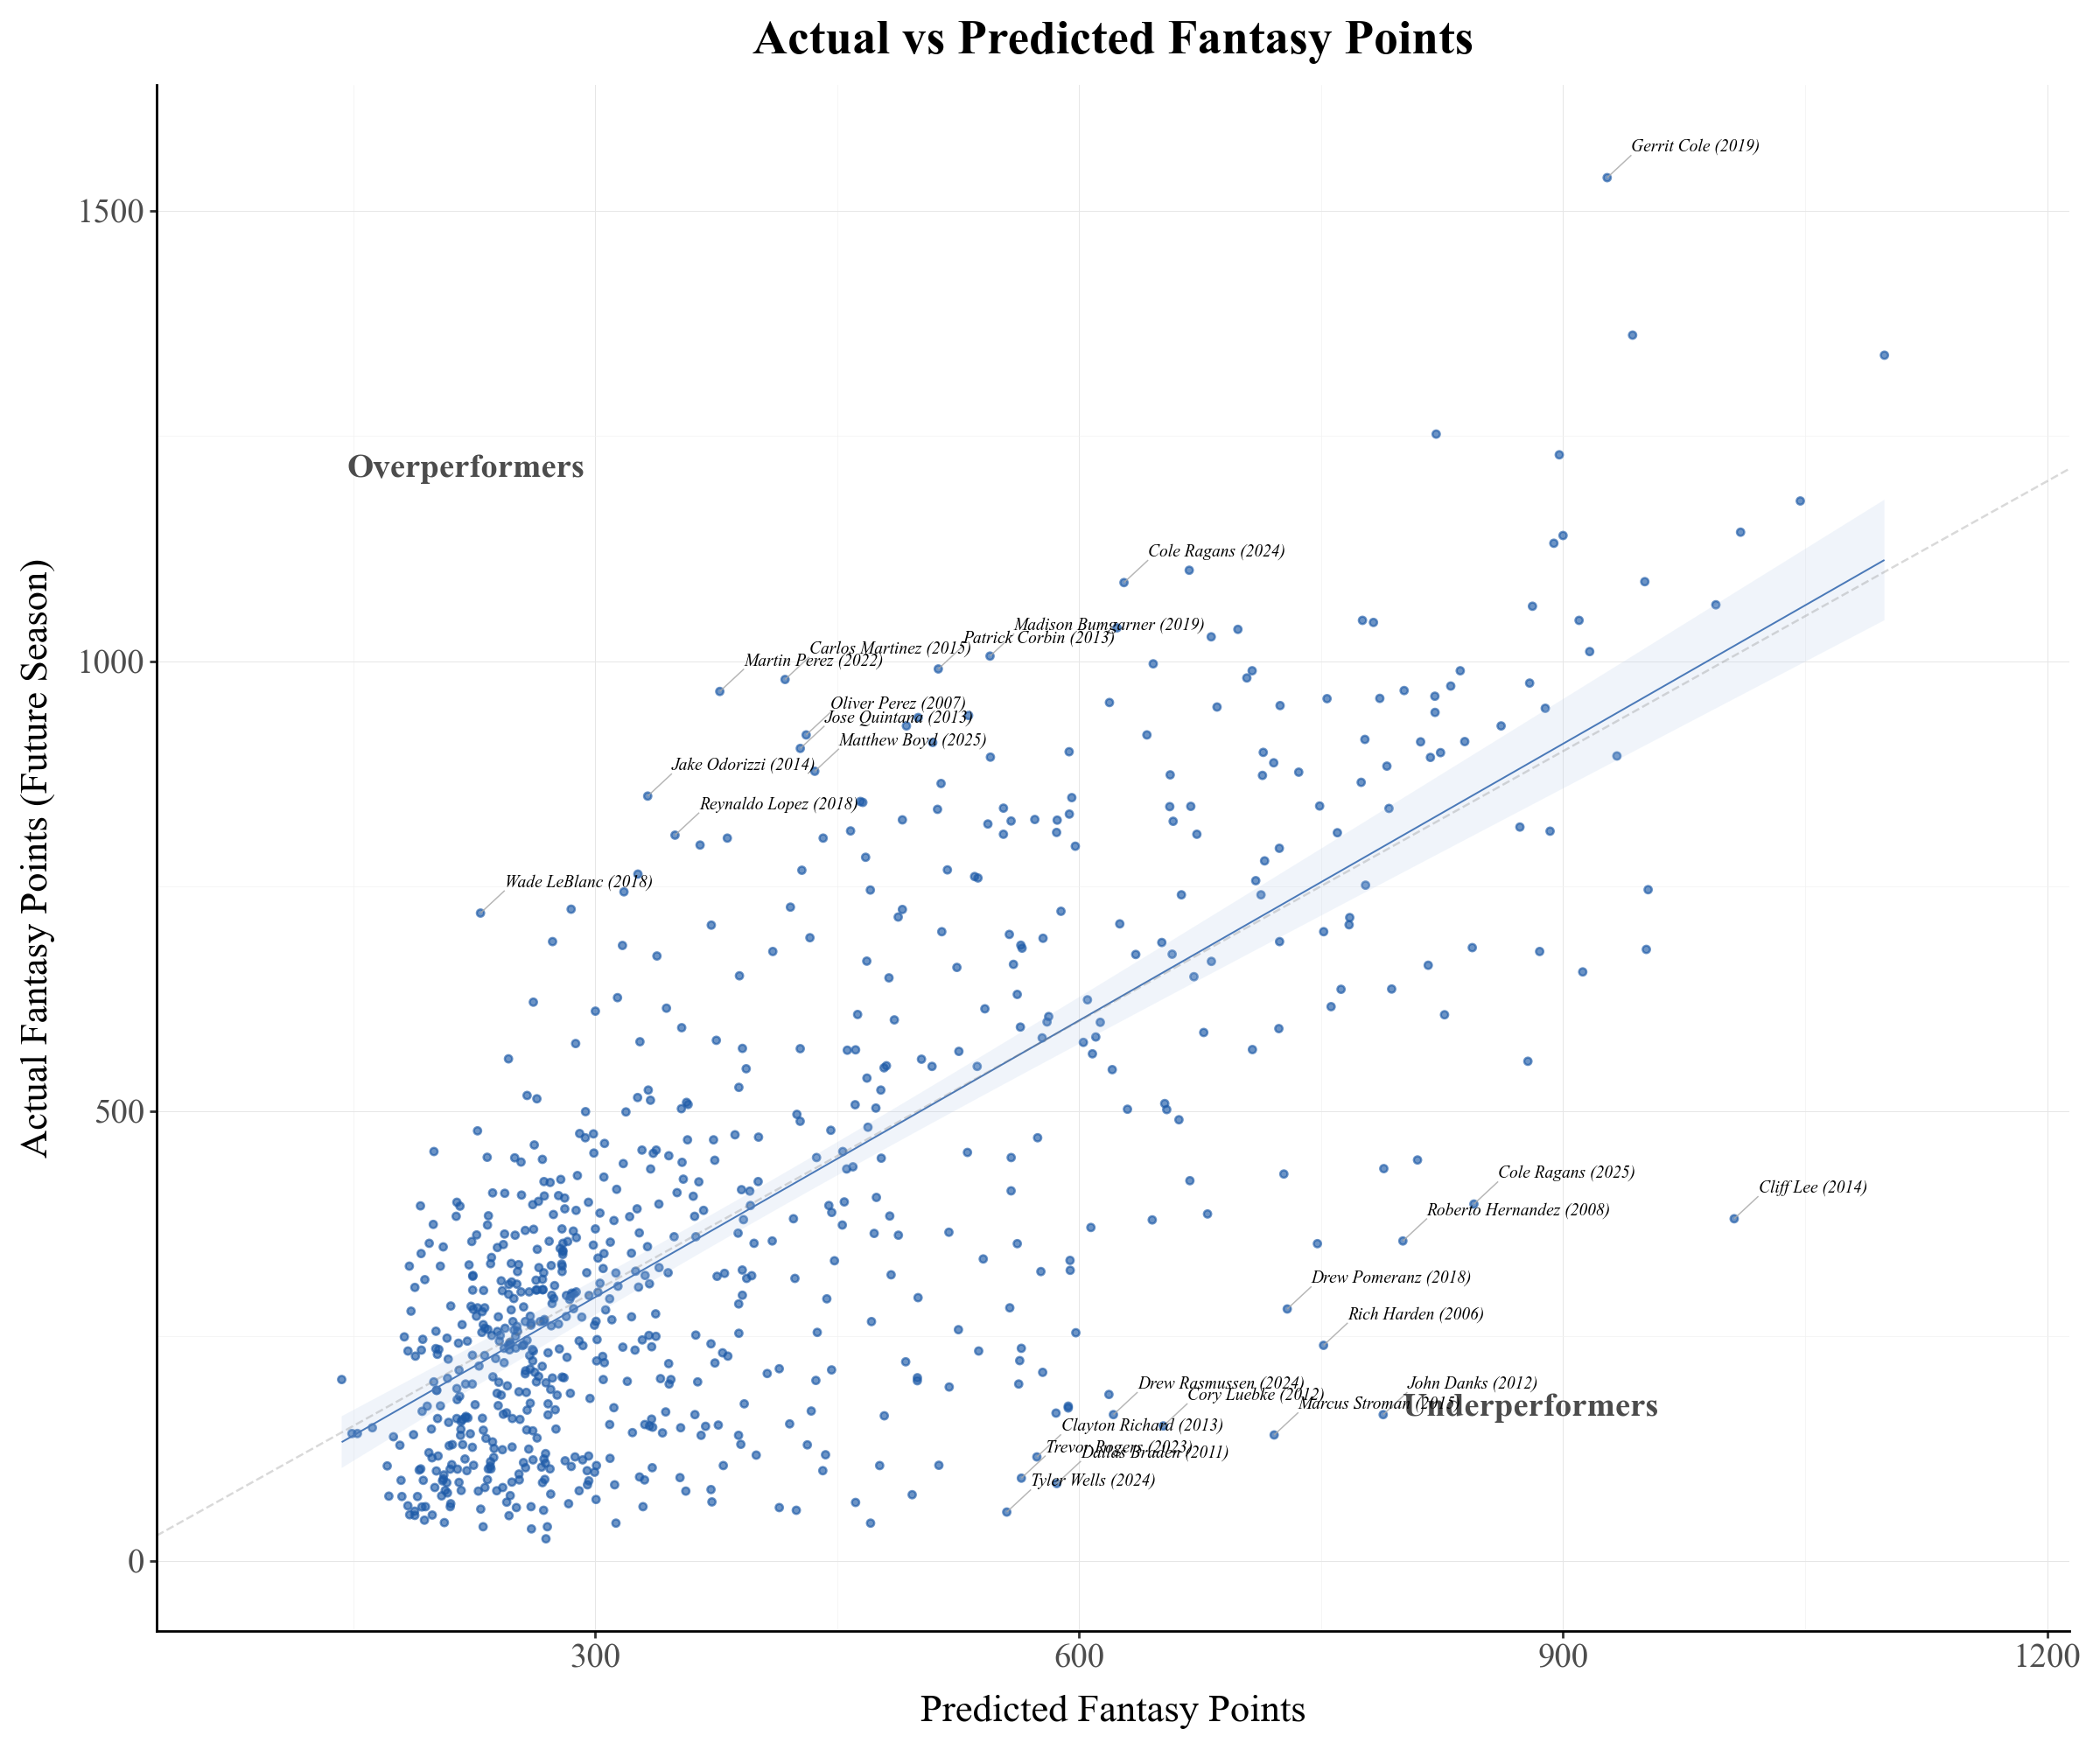

In [21]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

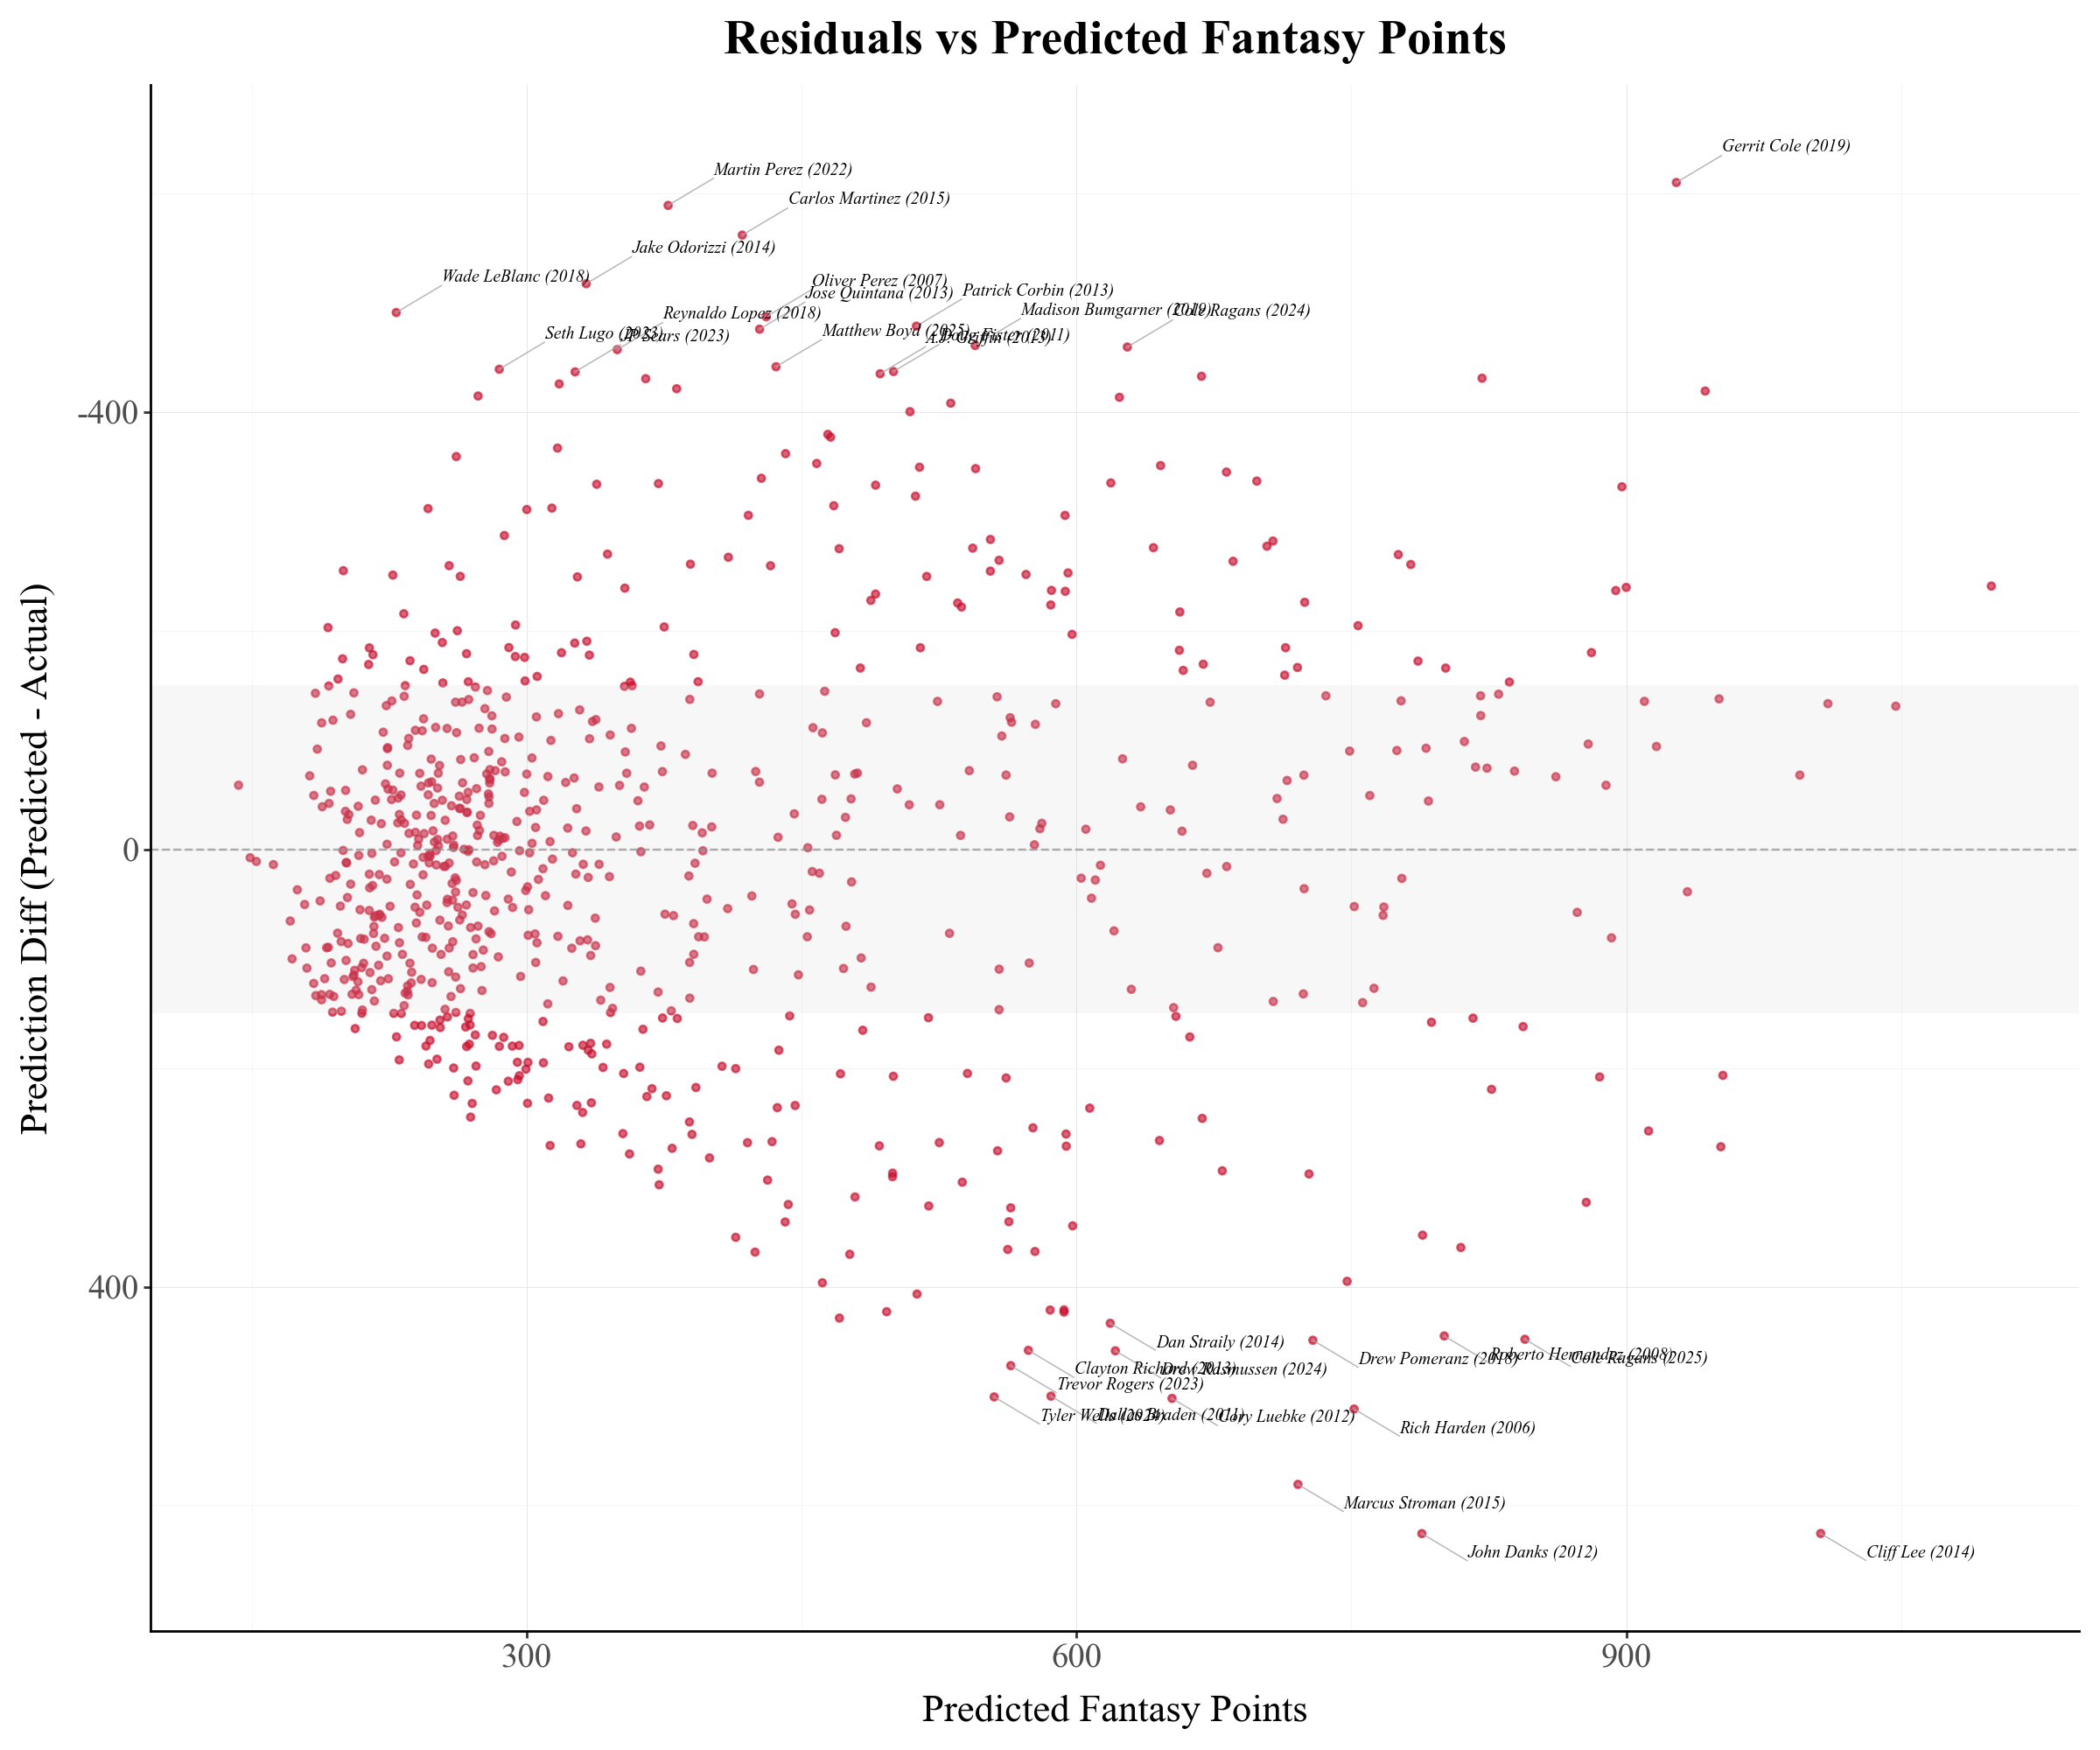

In [22]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

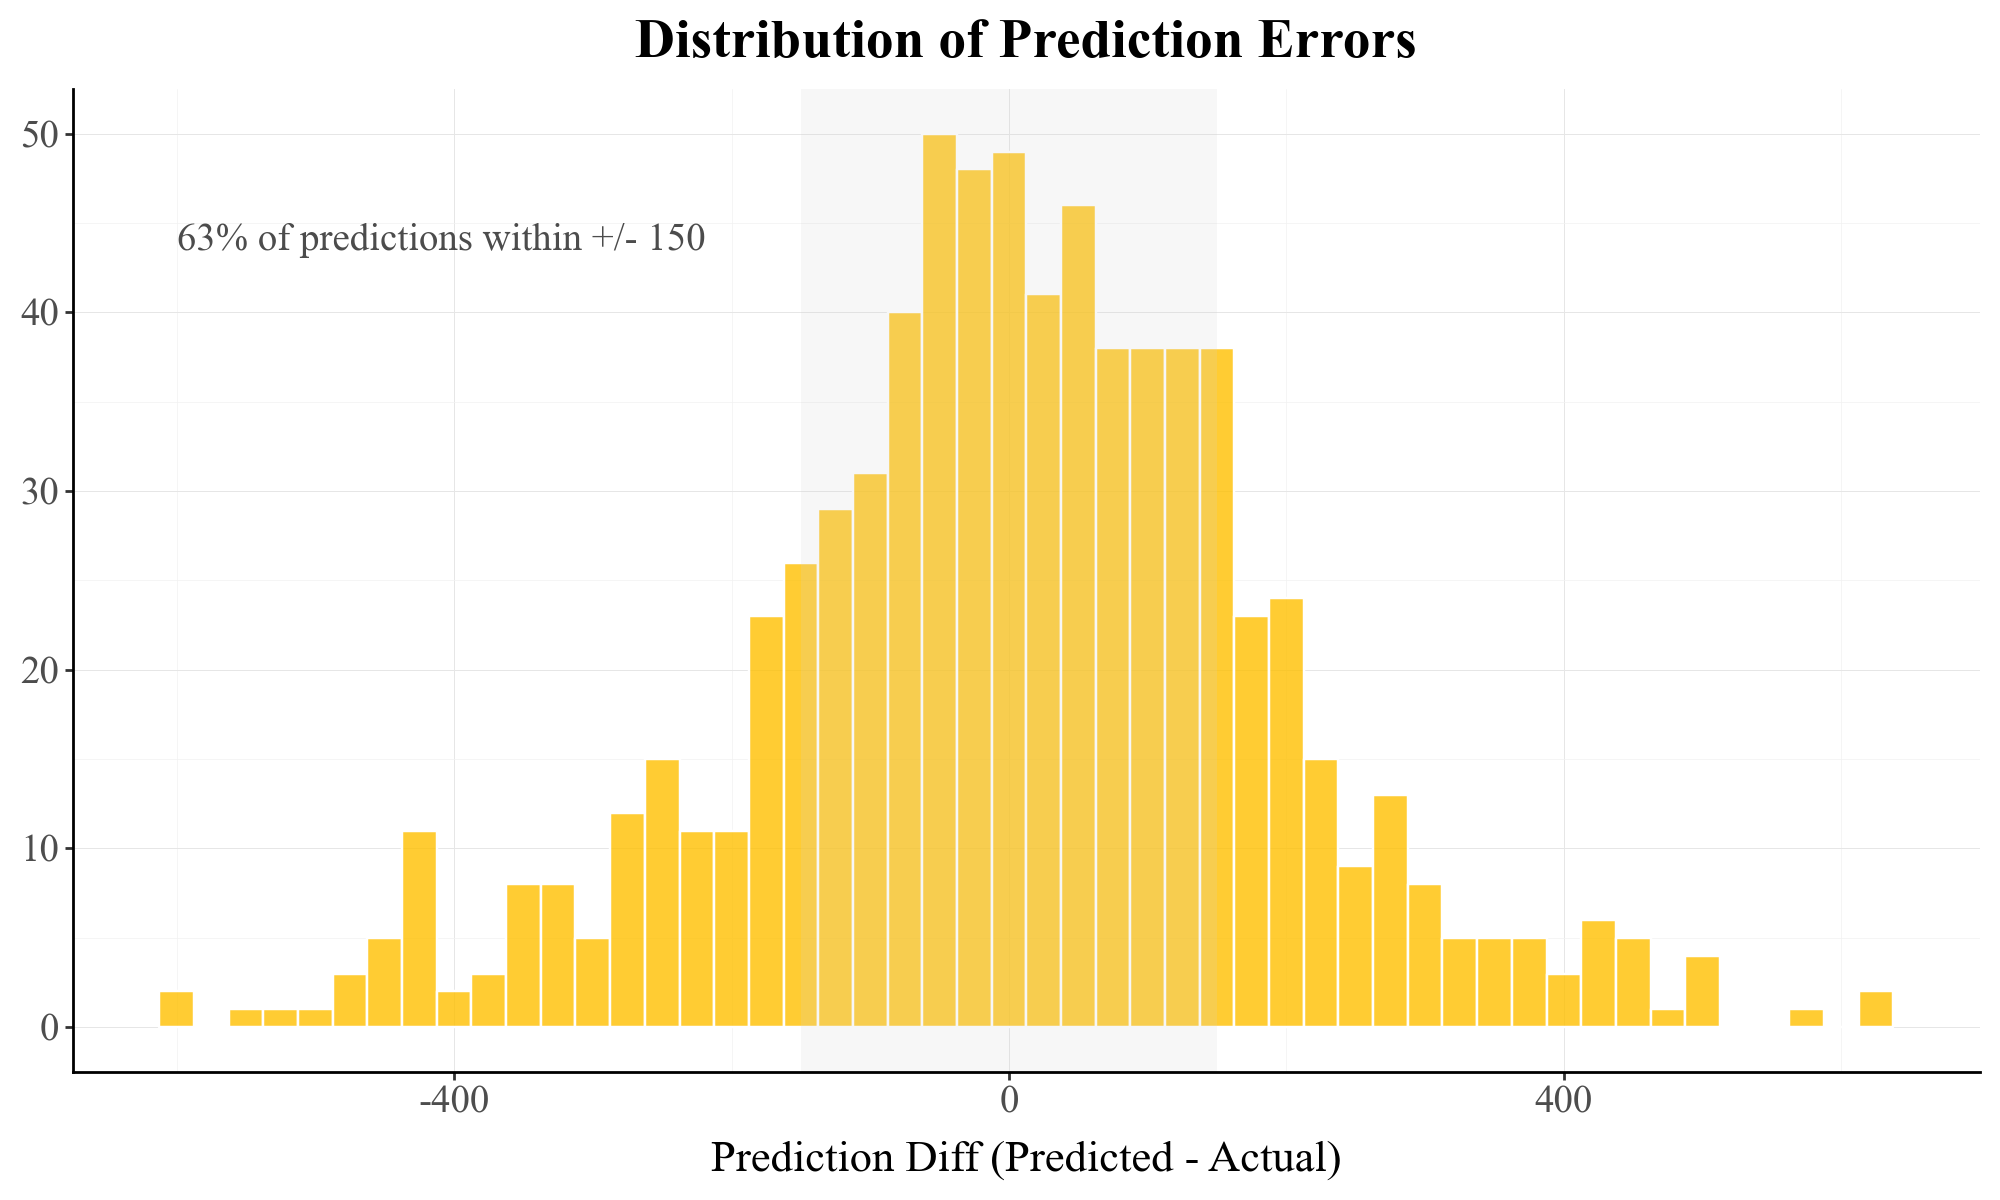

In [45]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=25,
    x_annotate=-600,    # custom annotation position
    y_annotate=45,      # custom annotation position
)
p3.show()

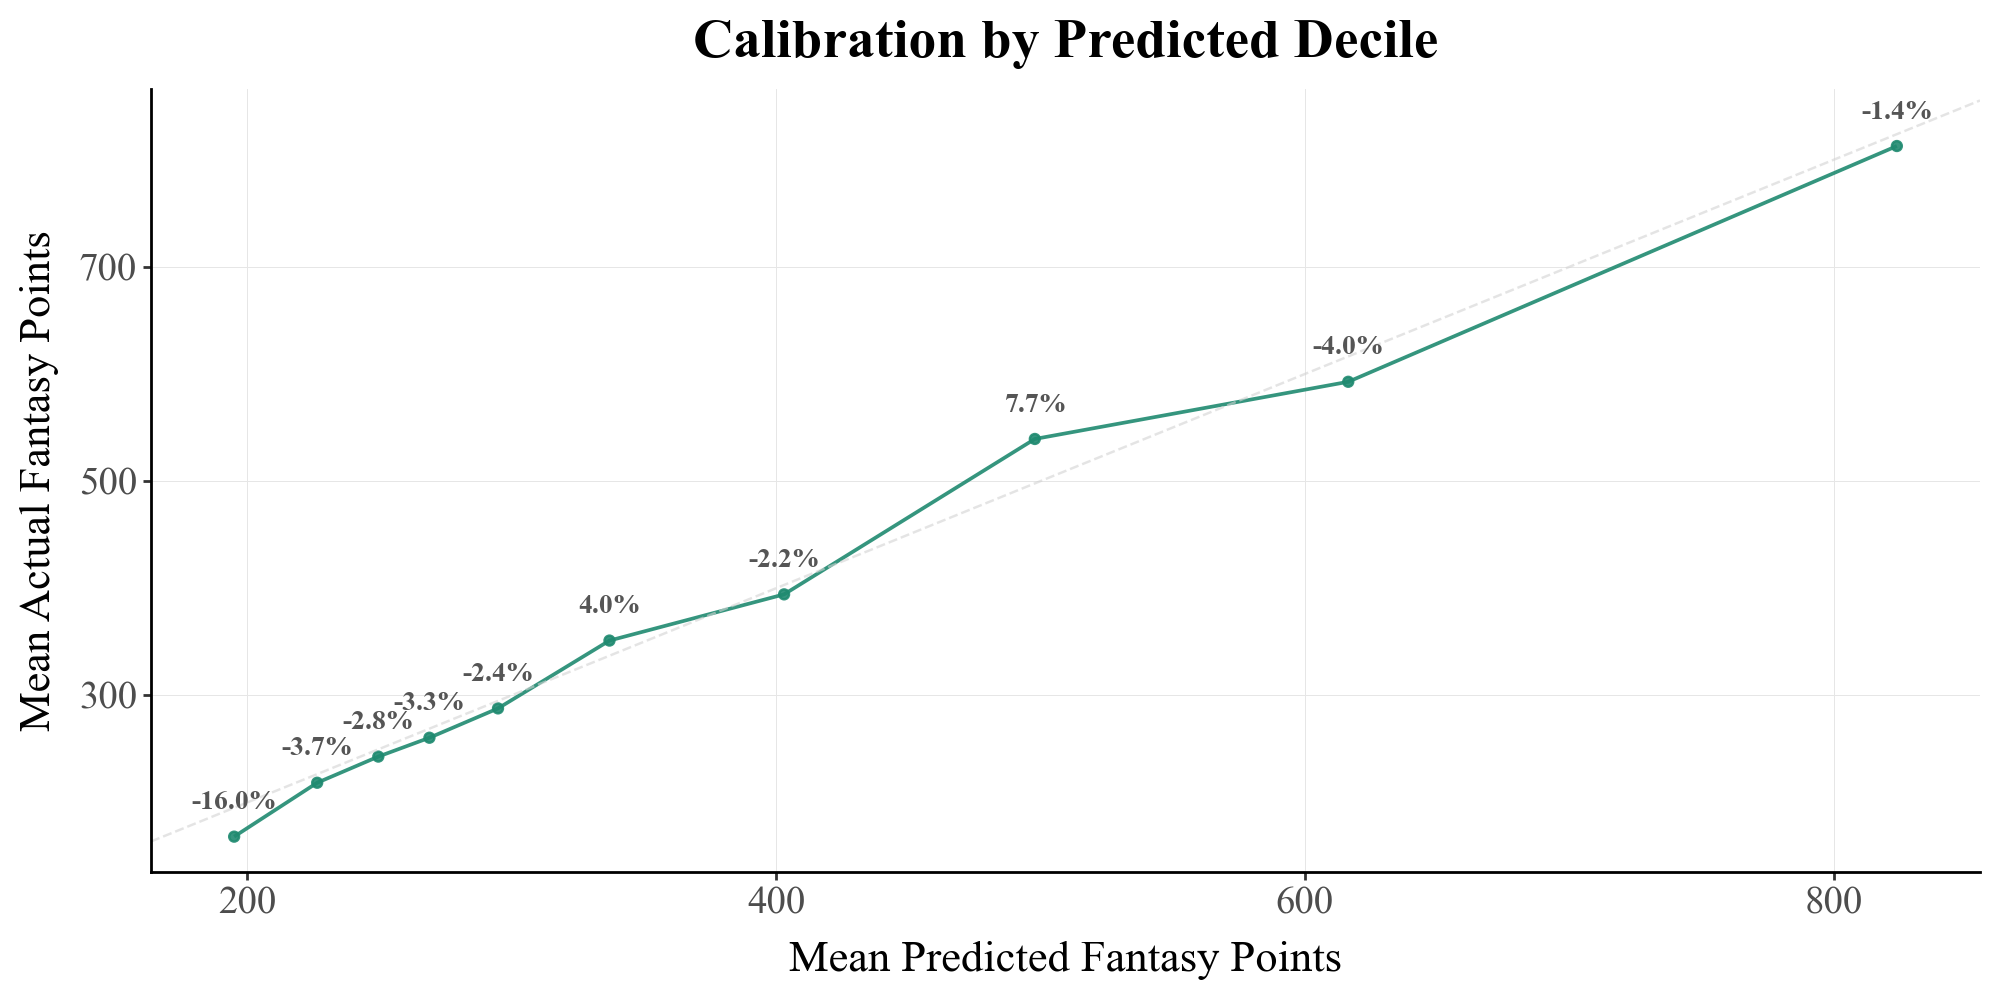

In [24]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [25]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [26]:
display(batting_pred.head(5))

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,player_tier_recent,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
92,15640,2025,Aaron Judge,33,152,541,179,94,30,2,...,star,1816.485718,1599.139011,1103.980805,1589.599141,2207.259191,608.120180,495.158205,1.153620,1103.278386
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,star,1781.939087,1596.939267,1228.859942,1529.582531,2045.703109,448.763842,368.079325,1.121859,816.843167
228,20123,2025,Juan Soto,26,160,577,152,88,20,1,...,star,1617.016968,1557.373174,1086.999389,1575.215987,1927.055406,369.682232,470.373785,0.737122,840.056017
59,13510,2025,Jose Ramirez,32,158,593,168,101,34,3,...,star,1563.977173,1401.684482,1046.037354,1405.894933,1711.052959,309.368478,355.647128,0.806317,665.015605
108,16478,2025,Kyle Schwarber,32,162,604,145,64,23,2,...,above_avg,1534.393921,1379.665287,955.276305,1380.647554,1736.448990,356.783703,424.388981,0.789375,781.172684


In [27]:
display(pitching_pred.head(5))

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,is_reliever,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,0,996.031311,917.014423,665.686197,917.538988,1215.159778,298.145356,251.328226,1.105599,549.473581
411,25880,2025,Hunter Brown,26,31,31,2964,1832,12,4.6,...,0,900.151428,911.452683,672.628443,897.256696,1249.831937,338.379254,238.824240,1.316378,577.203494
335,22267,2025,Tarik Skubal,28,31,31,2849,2003,13,6.6,...,0,896.587158,912.163398,646.850779,887.971800,1158.526014,246.362616,265.312619,0.868833,511.675235
279,20778,2025,Cristopher Sanchez,28,32,32,2897,1941,13,6.4,...,0,895.588928,844.191588,653.919137,861.028193,1082.000143,237.808556,190.272451,1.147967,428.081006
444,27463,2025,Garrett Crochet,26,32,32,3151,2114,18,5.8,...,0,874.704468,835.860408,524.624000,833.183023,1117.717776,281.857367,311.236409,0.859443,593.093776


In [28]:
# Splitting names into first and last
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
521,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1296.216967,388.492072,363.962616,1.016683,752.454689,max,muncy,LAD,3B,907.0
522,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1296.216967,388.492072,363.962616,1.016683,752.454689,max,muncy,ATH,"2B,3B,SS",564.0
523,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,854.930921,360.184752,373.007334,0.940670,733.192086,max,muncy,LAD,3B,907.0
524,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,854.930921,360.184752,373.007334,0.940670,733.192086,max,muncy,ATH,"2B,3B,SS",564.0


In [29]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

In [30]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
606,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,456.583138,246.351691,214.505545,1.126384,460.857236,luis,garcia,NYM,RP,264.0
607,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,456.583138,246.351691,214.505545,1.126384,460.857236,luis,garcia,NaN,SP,185.8


In [31]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [32]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

# Assigning position groups, cleaning player names, combining projections, and selecting final columns
batting_final = finalize_predictions(
    batting_final,
    mode="bat",
    position_overrides=BAT_POS_OVERRIDES,
)
pitching_final = finalize_predictions(
    pitching_final,
    mode="pit",
)

# Splitting the batters into infielders and outfielders
batting_final_if, batting_final_of = split_batters_if_of(batting_final)

# Creating final projected score, with a blended weight combining model and expert projections
# Creating initial player rankings based on final projection
# Filtering to player pool based on position
batting_final_if = (
    batting_final_if
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_if,
    )
)

batting_final_of = (
    batting_final_of
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_of,
    )
)

pitching_final = (
    pitching_final
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=pitcher_pool,
    )
)

batting_final = pd.concat([batting_final_if, batting_final_of])

# Assigning player position groups
batting_final = assign_position_group(batting_final, position_col = 'Position')
pitching_final = assign_position_group(pitching_final, position_col = 'Position')

# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)

In [33]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

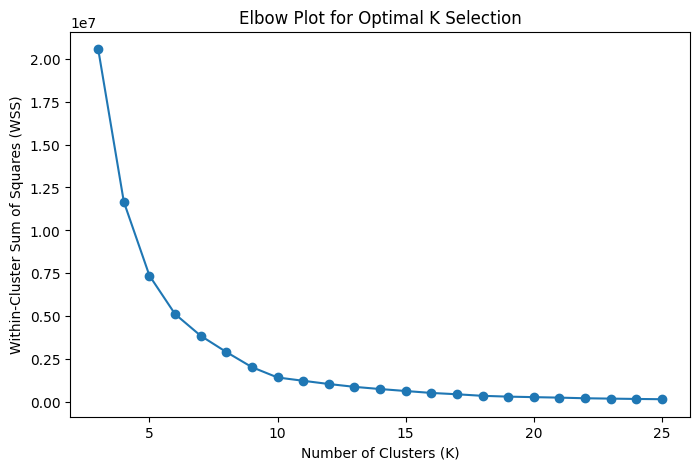

In [34]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [38]:
# Setting a K value and placing players into relative value tiers
final_df = segment_players(value_df, k = 19)

In [39]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [40]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)